In [7]:
import torch
import scipy
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from utils import calculate_Atilde, cSBM, MLP, LR, cSBM

In [8]:
class Device:
    
    def __init__(self, X, y, device_idx):
        
        self.idx = device_idx
        self.X = X.type(torch.FloatTensor)
        self.y = y
        self.n_k = X.shape[0]
        self.data_ids = np.arange(self.n_k)
        
        
    def upload_data(self):
        
        ids = np.random.choice(self.data_ids, size=self.n_k, replace=False)
        
        X = self.X[ids,:].view(self.n_k, 1, -1)
        
        y = self.y[ids].view(self.n_k, 1)
        
        return X, y
    

In [9]:
class Central_Machine:
    
    def __init__(self, device_list, A_tilde):
        
        self.A_tilde = A_tilde
        self.device_list = device_list
        self.N = len(device_list)
        self.cmodel = None
        self.dataset = None
        
    def init_central_parameters(self, input_dim, hidden_dim, output_dim, nn_type):
        
        """
        Initialize the central server parameter dictonary
        """
        
        if (nn_type == "MLP"):
            self.cmodel = MLP(input_dim, hidden_dim, output_dim)
            
        elif (nn_type == "LR"):
            self.cmodel = LR(input_dim, output_dim)
        
            
    def collect_data(self):
        
        Xs = []
        
        ys = []
        
        for device in self.device_list:
            
            X, y = device.upload_data()
            
            Xs.append(X)
            ys.append(y)
            
            
        # Xs; [n_k, N, p]
        # ys: [n_k, N] 
        Xs = torch.cat(Xs, dim=1)
        
        ys = torch.cat(ys, dim=1)
        
        self.dataset = torch.utils.data.TensorDataset(Xs, ys)
        
        return self.dataset

In [10]:
def train_GML_cSBM(csbm, A_tilde, num_train, hidden_dim, output_dim=2, n_k=40,
               batch_size=20, learning_rate=0.1, opt="Adam", num_epochs=10,
               nn_type="MLP"):
    
    N = A_tilde.shape[0]
    
    if (num_train > N):
        
        raise ValueError("The number of training nodes is larger than the total number of nodes!")
        
    
    input_dim= csbm.p
    
    device_list = []
    
    for i in range(N):
        
        device_i = Device(X=csbm.Xs[i], y=csbm.ys[i], device_idx=i)
        
        device_list.append(device_i)
    
    cm = Central_Machine(device_list, A_tilde)
    
    cm.init_central_parameters(input_dim, hidden_dim, output_dim, nn_type)
    
    if (num_train == N):
        
        train_indices = np.arange(N)
        
        test_indices = []
        
        np.random.shuffle(train_indices)
    
    else:
        
        class1_train = np.random.choice(a=csbm.class1_ids, size=int(num_train/2), replace=False)

        class2_train = np.random.choice(a=csbm.class2_ids, size=int(num_train/2), replace=False)

        train_indices = np.concatenate((class1_train, class2_train), axis=0)

        test_indices = list(set(np.arange(N)) - set(train_indices))
    
    
    if (opt == "Adam"):
        optimizer = optim.Adam(cm.cmodel.parameters())
            
    else:
        optimizer = optim.SGD(cm.cmodel.parameters(), lr=learning_rate)
        
    train_loss = []
    
    for ith in range(num_epochs):
        
        dataloader = torch.utils.data.DataLoader(cm.collect_data(), 
                                                 batch_size=batch_size, shuffle=True)
        for Xs, ys in dataloader:
            
            optimizer.zero_grad()
            
            # Hs: [batch_size, N, num_class]
            Hs = cm.cmodel(Xs)

            # Zs: [batch_size, N, num_class], ys: [m, N]
            Zs = torch.matmul(cm.A_tilde, Hs)

            # train_Zs: [batch_size, num_train, num_class]
            # train_ys: [batch_size, num_train]
            train_Zs = Zs[:,train_indices,:]
            train_ys = ys[:,train_indices]

            num_train = len(train_indices)

            loss = F.cross_entropy(train_Zs.view(batch_size*num_train, -1), train_ys.view(batch_size*num_train),
                                         reduction="mean")
            
            loss.backward()
            

            optimizer.step()
            
        for Xs, ys in dataloader:
            
            with torch.no_grad():
                
                # Hs: [batch_size, N, num_class]
                Hs = cm.cmodel(Xs)

                # Zs: [batch_size, N, num_class], ys: [m, N]
                Zs = torch.matmul(cm.A_tilde, Hs)

                # train_Zs: [batch_size, num_train, num_class]
                # train_ys: [batch_size, num_train]
                train_Zs = Zs[:,train_indices,:]
                train_ys = ys[:,train_indices]

                num_train = len(train_indices)

                average_train_loss = F.cross_entropy(train_Zs.view(batch_size*num_train, -1), train_ys.view(batch_size*num_train),
                                             reduction="mean")
                
                train_loss.append(average_train_loss)
                
                break
                
            
        if (num_epochs <= 100):
            if (ith % 10 == 0):
                print ("Epoch:", ith+1, "Average train loss:", average_train_loss.item())
                
        elif (num_epochs < 5000):
            if (ith % 100 == 0):
                print ("Epoch:", ith+1, "Average train loss:", average_train_loss.item())
                
        else:
            if (ith % 1000 == 0):
                print ("Epoch:", ith+1, "Average train loss:", average_train_loss.item())
                
                
                
                
    return train_loss

In [11]:
N = 100
p = 10
d = 5
mu = 1
l = 2
csbm = cSBM(N, p, d, mu, l)
A_tilde = calculate_Atilde(csbm.A, 100, 0.95)
csbm.generate_features(1)

In [12]:
tl = train_GML_cSBM(csbm, A_tilde, num_train=100, hidden_dim=200,
               batch_size=1, learning_rate=0.1, opt="Adam", num_epochs=10000,
               nn_type="LR", output_dim=2)

Epoch: 1 Average train loss: 0.6841844916343689
Epoch: 1001 Average train loss: 0.5557708740234375
Epoch: 2001 Average train loss: 0.4628486931324005
Epoch: 3001 Average train loss: 0.392476350069046
Epoch: 4001 Average train loss: 0.33692750334739685
Epoch: 5001 Average train loss: 0.2919013500213623
Epoch: 6001 Average train loss: 0.25481489300727844
Epoch: 7001 Average train loss: 0.2239454984664917
Epoch: 8001 Average train loss: 0.19808374345302582
Epoch: 9001 Average train loss: 0.17631162703037262


Text(0.5, 1.0, 'NonFedGML, n_k=2')

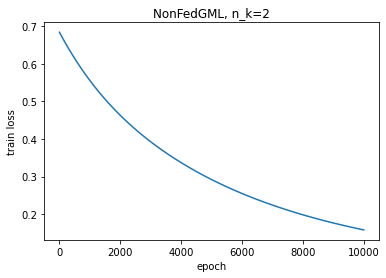

In [13]:
plt.plot(tl)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title("NonFedGML, n_k=2")